<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://storage.googleapis.com/dlops-content/public/univailogo.jpeg" height="50px"> <a href='https://welcome.univ.ai/AcceleratedMasters/ai5-c1/' target='_blank'><strong><font color="#324bd9">AI-5: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#324bd9">Mushroom Classification Models - Experiment Tracking</font>**

**Univ.AI**<br/>
**September 2022**<br/>
**Authors/Instructors:**<br/>
Pavlos Protopapas, Shivas Jayaram

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Installs**

In [23]:
!pip install -q wandb

**Imports**

In [24]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

# W&B
import wandb
from wandb.keras import WandbCallback

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [25]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [26]:
!nvidia-smi

Wed Sep 14 05:58:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |   9008MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [27]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [28]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_3_labels.zip", base_path="datasets", extract=True)
download_file("https://github.com/dlops-io/models/releases/download/v1.0/experiments.zip", base_path="experiments", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 2.629435455799103


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [29]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['amanita', 'crimini', 'oyster']
Full size of the dataset: 1643
data_list: [('amanita', 'datasets/mushrooms/amanita/410.jpg'), ('amanita', 'datasets/mushrooms/amanita/495.jpg'), ('amanita', 'datasets/mushrooms/amanita/431.jpg'), ('amanita', 'datasets/mushrooms/amanita/330.jpg'), ('amanita', 'datasets/mushrooms/amanita/258.jpg')]


### **View Images**

Let's take a look at the data.

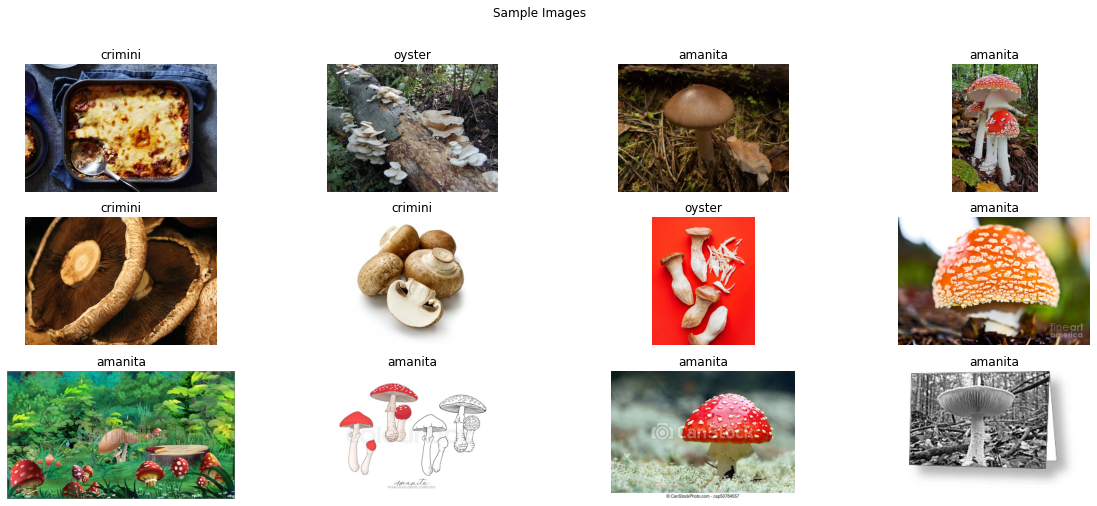

In [30]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Dataset Metrics**

In [31]:
# Compute dataset metrics
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
crimini    561
oyster     547
amanita    535
Name: label, dtype: int64
Image Width:
Min: 135.0  Max: 4288.0
Image Height:
Min: 120.0  Max: 4032.0
Size in memory: 4580.16 MB


## **<font color="#A41034">Build Data Pipelines</font>**

### **Load X & Y** 

Generate data_x and data_y

In [32]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 1643
data_y: 1643
data_x: ['datasets/mushrooms/amanita/410.jpg', 'datasets/mushrooms/amanita/495.jpg', 'datasets/mushrooms/amanita/431.jpg', 'datasets/mushrooms/amanita/330.jpg', 'datasets/mushrooms/amanita/258.jpg']
data_y: ['amanita', 'amanita', 'amanita', 'amanita', 'amanita']


### **Split Data** 
We split data into test, validation, & train

In [33]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 1330
validate_x count: 148
test_x count: 165


### **Create TF Datasets**

In [34]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32

train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
test_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


## **<font color="#A41034">Image Classificaton Models</font>**

### **Create Experiment**

We will use our util functions to create an experiment to keep track of hyper parameters, metrics, models etc.

In [35]:
# Create an experiment
create_experiment()

# Variable to switch to tutorial mode so pre-trained models are loaded and continued on training
LOAD_PREV_TRAINED = False
PREV_EXPERIMENT = "experiments/experiment_1632250736"

Signup in [WandB](https://wandb.ai/) to create a account for model tracking

In [36]:
# Login into wandb
wandb.login(key='649d985615d7b2944a1265dff006cc39a3126009') # Create an account in WandB and generate a key to replace this

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### **1) Two Block CNN Network**

In [37]:
# Build Model
def build_2_block_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='2_block')

  return model

### **Train**

Model: "2_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

Epoch 1/25
 6/42 [===>..........................] - ETA: 10s - loss: 1.1119 - accuracy: 0.3906

42/42 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.3917

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.8s


42/42 [==============================] - 18s 399ms/step - loss: 1.0972 - accuracy: 0.3917 - val_loss: 1.0848 - val_accuracy: 0.4797
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.4218

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.7s


42/42 [==============================] - 17s 394ms/step - loss: 1.0850 - accuracy: 0.4218 - val_loss: 1.0826 - val_accuracy: 0.3446
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.0692 - accuracy: 0.4436

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.7s


42/42 [==============================] - 19s 449ms/step - loss: 1.0692 - accuracy: 0.4436 - val_loss: 1.0381 - val_accuracy: 0.5270
Epoch 4/25
42/42 [==============================] - 15s 349ms/step - loss: 1.0447 - accuracy: 0.4850 - val_loss: 1.1007 - val_accuracy: 0.3446
Epoch 5/25
42/42 [==============================] - 14s 334ms/step - loss: 1.0181 - accuracy: 0.4932 - val_loss: 1.1663 - val_accuracy: 0.3378
Epoch 6/25
42/42 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.5414

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.7s


42/42 [==============================] - 16s 389ms/step - loss: 0.9821 - accuracy: 0.5414 - val_loss: 0.9401 - val_accuracy: 0.5541
Epoch 7/25
42/42 [==============================] - ETA: 0s - loss: 0.9177 - accuracy: 0.5910

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.9s


42/42 [==============================] - 17s 403ms/step - loss: 0.9177 - accuracy: 0.5910 - val_loss: 0.9020 - val_accuracy: 0.5473
Epoch 8/25
42/42 [==============================] - 14s 336ms/step - loss: 0.8913 - accuracy: 0.6203 - val_loss: 0.9108 - val_accuracy: 0.6351
Epoch 9/25
42/42 [==============================] - 14s 333ms/step - loss: 0.8281 - accuracy: 0.6331 - val_loss: 1.0993 - val_accuracy: 0.5068
Epoch 10/25
42/42 [==============================] - 14s 335ms/step - loss: 0.8281 - accuracy: 0.6233 - val_loss: 0.9496 - val_accuracy: 0.4932
Epoch 11/25
42/42 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.6639

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.8s


42/42 [==============================] - 17s 407ms/step - loss: 0.7654 - accuracy: 0.6639 - val_loss: 0.8262 - val_accuracy: 0.6757
Epoch 12/25
42/42 [==============================] - 15s 350ms/step - loss: 0.8321 - accuracy: 0.6429 - val_loss: 0.8462 - val_accuracy: 0.5608
Epoch 13/25
42/42 [==============================] - 15s 348ms/step - loss: 0.7503 - accuracy: 0.6737 - val_loss: 0.8510 - val_accuracy: 0.5946
Epoch 14/25
42/42 [==============================] - 15s 351ms/step - loss: 0.6608 - accuracy: 0.7180 - val_loss: 0.9140 - val_accuracy: 0.6149
Epoch 15/25
42/42 [==============================] - 16s 373ms/step - loss: 0.6623 - accuracy: 0.7218 - val_loss: 0.9185 - val_accuracy: 0.6284
Epoch 16/25
42/42 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7128

wandb: Adding directory to artifact (/content/wandb/run-20220914_060152-tqkm1by2/files/model-best)... Done. 0.7s


42/42 [==============================] - 17s 404ms/step - loss: 0.6689 - accuracy: 0.7128 - val_loss: 0.8204 - val_accuracy: 0.6824
Epoch 17/25
42/42 [==============================] - 15s 356ms/step - loss: 0.6140 - accuracy: 0.7421 - val_loss: 0.9229 - val_accuracy: 0.6149
Epoch 18/25
42/42 [==============================] - 14s 340ms/step - loss: 0.5648 - accuracy: 0.7805 - val_loss: 1.0512 - val_accuracy: 0.6081
Epoch 19/25
42/42 [==============================] - 15s 344ms/step - loss: 0.6078 - accuracy: 0.7346 - val_loss: 0.9250 - val_accuracy: 0.5878
Epoch 20/25
42/42 [==============================] - 14s 341ms/step - loss: 0.4772 - accuracy: 0.8188 - val_loss: 0.9276 - val_accuracy: 0.6216
Epoch 21/25
42/42 [==============================] - 15s 356ms/step - loss: 0.4747 - accuracy: 0.8090 - val_loss: 1.1630 - val_accuracy: 0.5405
Epoch 22/25
42/42 [==============================] - 15s 362ms/step - loss: 0.4313 - accuracy: 0.8195 - val_loss: 0.9213 - val_accuracy: 0.6419
Epoc

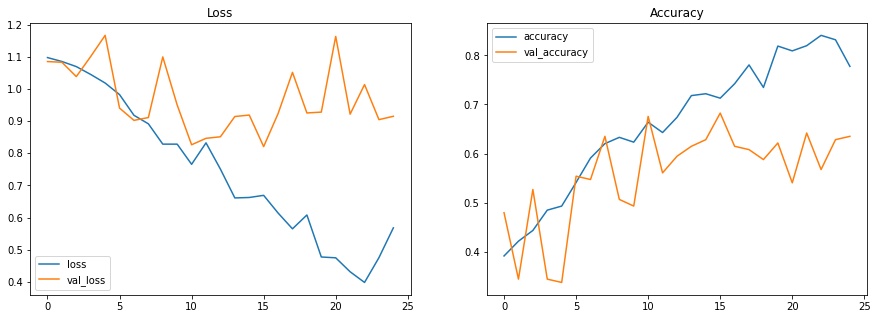

6/6 [==============================] - 1s 206ms/step - loss: 0.8939 - accuracy: 0.6303
[0.8938999772071838, 0.6303030252456665]


In [38]:
############################
# Training Params
############################
learning_rate = 0.01
initial_epoch = 0
epochs = 25

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "2_block"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_2_block_model(image_height, image_width, num_channels, num_classes)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()


# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **2) Four Block CNN Network**

In [39]:
# Build Model
def build_4_block_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='4_block')

  return model

### **Train**

Model: "4_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

accuracy,▁▁▂▂▃▃▄▅▅▅▅▅▅▆▆▆▆▇▆█████▇
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,███▇▇▇▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▁▁▂▃
val_accuracy,▄▁▅▁▁▅▅▇▄▄█▆▆▇▇█▇▆▆▇▅▇▆▇▇
val_loss,▆▆▅▇█▃▃▃▇▄▁▂▂▃▃▁▃▆▃▃█▃▅▃▃
GFLOPs,4.74384
accuracy,0.77744
best_epoch,15
best_val_loss,0.82042
epoch,24
loss,0.56787


Epoch 1/25
 6/42 [===>..........................] - ETA: 15s - loss: 1.0984 - accuracy: 0.3958

42/42 [==============================] - ETA: 0s - loss: 1.0984 - accuracy: 0.3331

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 20s 464ms/step - loss: 1.0984 - accuracy: 0.3331 - val_loss: 1.0971 - val_accuracy: 0.3581
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.3429

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 19s 445ms/step - loss: 1.0976 - accuracy: 0.3429 - val_loss: 1.0957 - val_accuracy: 0.3581
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.3519

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 21s 508ms/step - loss: 1.0969 - accuracy: 0.3519 - val_loss: 1.0946 - val_accuracy: 0.3581
Epoch 4/25
42/42 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.3489

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.3s


42/42 [==============================] - 27s 636ms/step - loss: 1.0961 - accuracy: 0.3489 - val_loss: 1.0928 - val_accuracy: 0.3649
Epoch 5/25
42/42 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.3579

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.3s


42/42 [==============================] - 32s 747ms/step - loss: 1.0948 - accuracy: 0.3579 - val_loss: 1.0906 - val_accuracy: 0.4189
Epoch 6/25
42/42 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.3722

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 33s 790ms/step - loss: 1.0928 - accuracy: 0.3722 - val_loss: 1.0883 - val_accuracy: 0.3919
Epoch 7/25
42/42 [==============================] - ETA: 0s - loss: 1.0900 - accuracy: 0.4293

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 31s 723ms/step - loss: 1.0900 - accuracy: 0.4293 - val_loss: 1.0823 - val_accuracy: 0.4797
Epoch 8/25
42/42 [==============================] - ETA: 0s - loss: 1.0858 - accuracy: 0.4451

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 31s 726ms/step - loss: 1.0858 - accuracy: 0.4451 - val_loss: 1.0748 - val_accuracy: 0.4797
Epoch 9/25
42/42 [==============================] - 30s 700ms/step - loss: 1.0803 - accuracy: 0.4556 - val_loss: 1.0858 - val_accuracy: 0.3514
Epoch 10/25
42/42 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.4624

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 34s 804ms/step - loss: 1.0727 - accuracy: 0.4624 - val_loss: 1.0509 - val_accuracy: 0.4595
Epoch 11/25
42/42 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.4684

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 32s 764ms/step - loss: 1.0635 - accuracy: 0.4684 - val_loss: 1.0380 - val_accuracy: 0.4865
Epoch 12/25
42/42 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.4714

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.3s


42/42 [==============================] - 28s 664ms/step - loss: 1.0567 - accuracy: 0.4714 - val_loss: 1.0360 - val_accuracy: 0.4730
Epoch 13/25
42/42 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.4835

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 30s 699ms/step - loss: 1.0440 - accuracy: 0.4835 - val_loss: 1.0293 - val_accuracy: 0.4865
Epoch 14/25
42/42 [==============================] - 22s 518ms/step - loss: 1.0302 - accuracy: 0.4970 - val_loss: 1.0682 - val_accuracy: 0.4189
Epoch 15/25
42/42 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.4940

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 23s 550ms/step - loss: 1.0214 - accuracy: 0.4940 - val_loss: 1.0245 - val_accuracy: 0.4932
Epoch 16/25
42/42 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.5090

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 22s 531ms/step - loss: 1.0086 - accuracy: 0.5090 - val_loss: 1.0057 - val_accuracy: 0.4662
Epoch 17/25
42/42 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.5045

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 22s 526ms/step - loss: 0.9977 - accuracy: 0.5045 - val_loss: 0.9926 - val_accuracy: 0.5473
Epoch 18/25
42/42 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.5308

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.4s


42/42 [==============================] - 23s 532ms/step - loss: 0.9712 - accuracy: 0.5308 - val_loss: 0.9885 - val_accuracy: 0.5000
Epoch 19/25
42/42 [==============================] - 20s 463ms/step - loss: 0.9632 - accuracy: 0.5368 - val_loss: 1.0209 - val_accuracy: 0.4595
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.9506 - accuracy: 0.5451

wandb: Adding directory to artifact (/content/wandb/run-20220914_060941-1dq189h1/files/model-best)... Done. 0.5s


42/42 [==============================] - 24s 558ms/step - loss: 0.9506 - accuracy: 0.5451 - val_loss: 0.9708 - val_accuracy: 0.5541
Epoch 21/25
42/42 [==============================] - 20s 476ms/step - loss: 0.9400 - accuracy: 0.5707 - val_loss: 1.0939 - val_accuracy: 0.4730
Epoch 22/25
42/42 [==============================] - 22s 513ms/step - loss: 0.9279 - accuracy: 0.5669 - val_loss: 1.0451 - val_accuracy: 0.5541
Epoch 23/25
42/42 [==============================] - 21s 484ms/step - loss: 0.9210 - accuracy: 0.5759 - val_loss: 1.0124 - val_accuracy: 0.5270
Epoch 24/25
42/42 [==============================] - 22s 509ms/step - loss: 0.9124 - accuracy: 0.5737 - val_loss: 1.0085 - val_accuracy: 0.5338
Epoch 25/25
42/42 [==============================] - 23s 527ms/step - loss: 0.8943 - accuracy: 0.5932 - val_loss: 1.0310 - val_accuracy: 0.4662
Training execution time (mins) 12.61796422402064


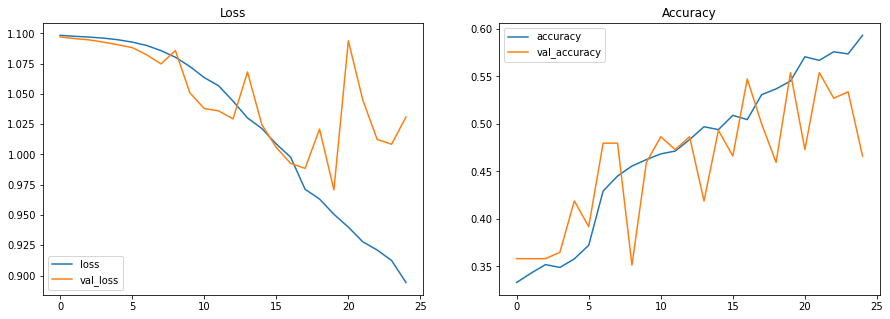

6/6 [==============================] - 3s 423ms/step - loss: 1.0103 - accuracy: 0.5030
[1.0102629661560059, 0.5030303001403809]


In [40]:
############################
# Training Params
############################
learning_rate = 0.01
initial_epoch = 0
epochs = 25

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "4_block"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_4_block_model(image_height, image_width, num_channels, num_classes)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)
  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **3) VGG Style Network**

In [41]:
# Build Model
def build_vgg_style_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='vgg_style')

  return model

### **Train**

Model: "vgg_style"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                         

accuracy,▁▁▂▁▂▂▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇█▇█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,████████▇▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁
val_accuracy,▁▁▁▁▃▂▅▅▁▅▆▅▆▃▆▅█▆▅█▅█▇▇▅
val_loss,██████▇▇▇▅▅▅▄▆▄▃▂▂▄▁█▅▃▃▄
GFLOPs,10.27545
accuracy,0.59323
best_epoch,19
best_val_loss,0.97082
epoch,24
loss,0.89427


Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.3331

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 33s 757ms/step - loss: 1.0985 - accuracy: 0.3331 - val_loss: 1.0972 - val_accuracy: 0.3581
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 35s 835ms/step - loss: 1.0977 - accuracy: 0.3459 - val_loss: 1.0965 - val_accuracy: 0.3581
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 1.0973 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 25s 602ms/step - loss: 1.0973 - accuracy: 0.3459 - val_loss: 1.0959 - val_accuracy: 0.3581
Epoch 4/15
42/42 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 25s 587ms/step - loss: 1.0969 - accuracy: 0.3459 - val_loss: 1.0952 - val_accuracy: 0.3581
Epoch 5/15
42/42 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 24s 567ms/step - loss: 1.0964 - accuracy: 0.3459 - val_loss: 1.0944 - val_accuracy: 0.3581
Epoch 6/15
42/42 [==============================] - ETA: 0s - loss: 1.0957 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.6s


42/42 [==============================] - 23s 544ms/step - loss: 1.0957 - accuracy: 0.3459 - val_loss: 1.0934 - val_accuracy: 0.3581
Epoch 7/15
42/42 [==============================] - ETA: 0s - loss: 1.0951 - accuracy: 0.3459

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 22s 503ms/step - loss: 1.0951 - accuracy: 0.3459 - val_loss: 1.0922 - val_accuracy: 0.3581
Epoch 8/15
42/42 [==============================] - ETA: 0s - loss: 1.0938 - accuracy: 0.3511

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.8s


42/42 [==============================] - 21s 504ms/step - loss: 1.0938 - accuracy: 0.3511 - val_loss: 1.0907 - val_accuracy: 0.3784
Epoch 9/15
42/42 [==============================] - ETA: 0s - loss: 1.0925 - accuracy: 0.3805

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 21s 486ms/step - loss: 1.0925 - accuracy: 0.3805 - val_loss: 1.0884 - val_accuracy: 0.4189
Epoch 10/15
42/42 [==============================] - ETA: 0s - loss: 1.0910 - accuracy: 0.3767

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 20s 470ms/step - loss: 1.0910 - accuracy: 0.3767 - val_loss: 1.0851 - val_accuracy: 0.4257
Epoch 11/15
42/42 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.3887

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.8s


42/42 [==============================] - 20s 475ms/step - loss: 1.0886 - accuracy: 0.3887 - val_loss: 1.0832 - val_accuracy: 0.4662
Epoch 12/15
42/42 [==============================] - ETA: 0s - loss: 1.0855 - accuracy: 0.4331

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 20s 468ms/step - loss: 1.0855 - accuracy: 0.4331 - val_loss: 1.0745 - val_accuracy: 0.4459
Epoch 13/15
42/42 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.4444

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 20s 469ms/step - loss: 1.0809 - accuracy: 0.4444 - val_loss: 1.0690 - val_accuracy: 0.4459
Epoch 14/15
42/42 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.4586

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 20s 470ms/step - loss: 1.0764 - accuracy: 0.4586 - val_loss: 1.0557 - val_accuracy: 0.4189
Epoch 15/15
42/42 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.4571

wandb: Adding directory to artifact (/content/wandb/run-20220914_062242-15haksca/files/model-best)... Done. 0.7s


42/42 [==============================] - 20s 464ms/step - loss: 1.0700 - accuracy: 0.4571 - val_loss: 1.0516 - val_accuracy: 0.4595
Training execution time (mins) 6.806858682632447


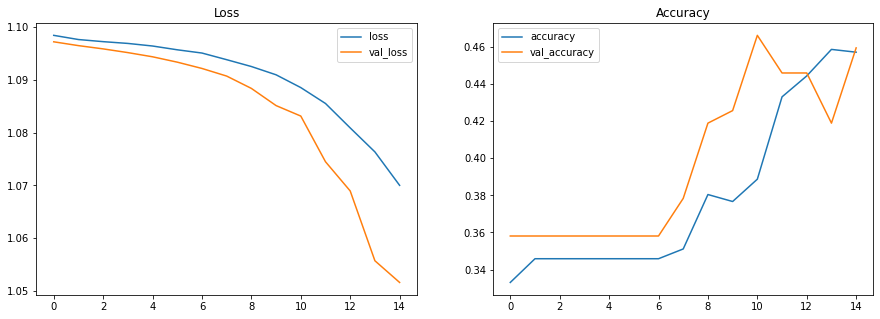

6/6 [==============================] - 2s 204ms/step - loss: 1.1087 - accuracy: 0.4121
[1.1087367534637451, 0.4121212065219879]


In [42]:
############################
# Training Params
############################
learning_rate = 0.01
initial_epoch = 0
epochs = 15

# Free up memory
K.clear_session()


# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "vgg_style"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_vgg_style_model(image_height, image_width, num_channels, num_classes)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **4) MobileNet - Transfer Learning**

In [43]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(units=128, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

Model: "mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________
None


accuracy,▁▂▂▂▂▂▂▂▄▃▄▇▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█████▇▇▇▇▆▆▅▄▃▁
val_accuracy,▁▁▁▁▁▁▁▂▅▅█▇▇▅█
val_loss,█████▇▇▇▇▆▆▅▄▂▁
GFLOPs,11.20712
accuracy,0.45714
best_epoch,14
best_val_loss,1.0516
epoch,14
loss,1.07002


Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 107.6696 - accuracy: 0.4511

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.2s


42/42 [==============================] - 35s 776ms/step - loss: 107.6696 - accuracy: 0.4511 - val_loss: 106.0447 - val_accuracy: 0.5405
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 104.6719 - accuracy: 0.6098

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 777ms/step - loss: 104.6719 - accuracy: 0.6098 - val_loss: 103.1975 - val_accuracy: 0.6486
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 101.8546 - accuracy: 0.6955

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 779ms/step - loss: 101.8546 - accuracy: 0.6955 - val_loss: 100.4310 - val_accuracy: 0.7365
Epoch 4/15
42/42 [==============================] - ETA: 0s - loss: 99.1142 - accuracy: 0.7707

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 786ms/step - loss: 99.1142 - accuracy: 0.7707 - val_loss: 97.7343 - val_accuracy: 0.7973
Epoch 5/15
42/42 [==============================] - ETA: 0s - loss: 96.4355 - accuracy: 0.8143

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 34s 811ms/step - loss: 96.4355 - accuracy: 0.8143 - val_loss: 95.0844 - val_accuracy: 0.8108
Epoch 6/15
42/42 [==============================] - ETA: 0s - loss: 93.8092 - accuracy: 0.8316

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 788ms/step - loss: 93.8092 - accuracy: 0.8316 - val_loss: 92.4876 - val_accuracy: 0.8243
Epoch 7/15
42/42 [==============================] - ETA: 0s - loss: 91.2300 - accuracy: 0.8481

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 790ms/step - loss: 91.2300 - accuracy: 0.8481 - val_loss: 89.9316 - val_accuracy: 0.8446
Epoch 8/15
42/42 [==============================] - ETA: 0s - loss: 88.6942 - accuracy: 0.8579

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 782ms/step - loss: 88.6942 - accuracy: 0.8579 - val_loss: 87.4197 - val_accuracy: 0.8514
Epoch 9/15
42/42 [==============================] - ETA: 0s - loss: 86.1984 - accuracy: 0.8609

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 795ms/step - loss: 86.1984 - accuracy: 0.8609 - val_loss: 84.9447 - val_accuracy: 0.8649
Epoch 10/15
42/42 [==============================] - ETA: 0s - loss: 83.7421 - accuracy: 0.8669

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 34s 817ms/step - loss: 83.7421 - accuracy: 0.8669 - val_loss: 82.5103 - val_accuracy: 0.8784
Epoch 11/15
42/42 [==============================] - ETA: 0s - loss: 81.3249 - accuracy: 0.8714

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 803ms/step - loss: 81.3249 - accuracy: 0.8714 - val_loss: 80.1140 - val_accuracy: 0.8919
Epoch 12/15
42/42 [==============================] - ETA: 0s - loss: 78.9454 - accuracy: 0.8767

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 798ms/step - loss: 78.9454 - accuracy: 0.8767 - val_loss: 77.7547 - val_accuracy: 0.8919
Epoch 13/15
42/42 [==============================] - ETA: 0s - loss: 76.6034 - accuracy: 0.8797

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 781ms/step - loss: 76.6034 - accuracy: 0.8797 - val_loss: 75.4324 - val_accuracy: 0.8986
Epoch 14/15
42/42 [==============================] - ETA: 0s - loss: 74.2978 - accuracy: 0.8850

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 782ms/step - loss: 74.2978 - accuracy: 0.8850 - val_loss: 73.1472 - val_accuracy: 0.8986
Epoch 15/15
42/42 [==============================] - ETA: 0s - loss: 72.0276 - accuracy: 0.8910

wandb: Adding directory to artifact (/content/wandb/run-20220914_062950-6q6noc9d/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 805ms/step - loss: 72.0276 - accuracy: 0.8910 - val_loss: 70.8957 - val_accuracy: 0.9122
Training execution time (mins) 9.090123716990153


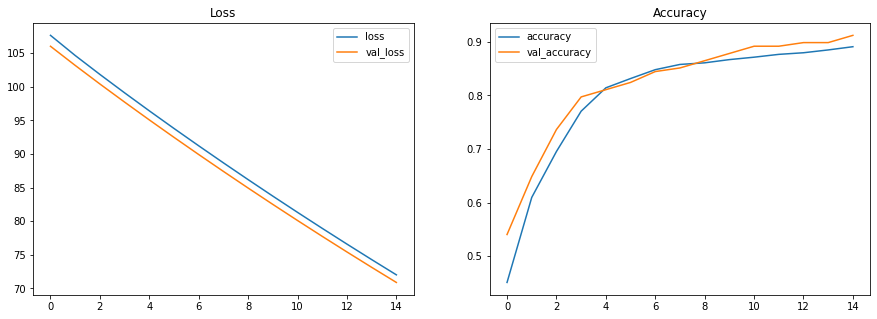

6/6 [==============================] - 2s 271ms/step - loss: 70.9257 - accuracy: 0.8727
[70.92574310302734, 0.8727272748947144]


In [44]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 15

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "mobilenetv2_train_base_False"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **Train - Fine-Tuning**

Unfreeze the base

Model: "mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________________________________
None


accuracy,▁▄▅▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇█████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
GFLOPs,0.29969
accuracy,0.89098
best_epoch,14
best_val_loss,70.89574
epoch,14
loss,72.02764


Epoch 1/10
 6/42 [===>..........................] - ETA: 7s - loss: 108.8407 - accuracy: 0.4010

42/42 [==============================] - ETA: 0s - loss: 107.4394 - accuracy: 0.5669

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.1s


42/42 [==============================] - 41s 864ms/step - loss: 107.4394 - accuracy: 0.5669 - val_loss: 105.8675 - val_accuracy: 0.7297
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 104.4369 - accuracy: 0.7737

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.2s


42/42 [==============================] - 35s 832ms/step - loss: 104.4369 - accuracy: 0.7737 - val_loss: 102.9990 - val_accuracy: 0.8311
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 101.6098 - accuracy: 0.8511

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.1s


42/42 [==============================] - 35s 844ms/step - loss: 101.6098 - accuracy: 0.8511 - val_loss: 100.2465 - val_accuracy: 0.8514
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 98.8844 - accuracy: 0.8782

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.2s


42/42 [==============================] - 36s 861ms/step - loss: 98.8844 - accuracy: 0.8782 - val_loss: 97.5579 - val_accuracy: 0.8514
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 96.2191 - accuracy: 0.8955

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.2s


42/42 [==============================] - 35s 841ms/step - loss: 96.2191 - accuracy: 0.8955 - val_loss: 94.9252 - val_accuracy: 0.8581
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 93.6083 - accuracy: 0.9030

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.1s


42/42 [==============================] - 35s 831ms/step - loss: 93.6083 - accuracy: 0.9030 - val_loss: 92.3413 - val_accuracy: 0.8716
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 91.0381 - accuracy: 0.9120

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.1s


42/42 [==============================] - 36s 860ms/step - loss: 91.0381 - accuracy: 0.9120 - val_loss: 89.7943 - val_accuracy: 0.8649
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 88.5048 - accuracy: 0.9226

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.2s


42/42 [==============================] - 35s 851ms/step - loss: 88.5048 - accuracy: 0.9226 - val_loss: 87.2885 - val_accuracy: 0.8716
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 86.0321 - accuracy: 0.9203

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.1s


42/42 [==============================] - 36s 861ms/step - loss: 86.0321 - accuracy: 0.9203 - val_loss: 84.8246 - val_accuracy: 0.8716
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 83.5685 - accuracy: 0.9323

wandb: Adding directory to artifact (/content/wandb/run-20220914_063919-3jkcrpom/files/model-best)... Done. 0.2s


42/42 [==============================] - 35s 845ms/step - loss: 83.5685 - accuracy: 0.9323 - val_loss: 82.3920 - val_accuracy: 0.8784
Training execution time (mins) 6.437516856193542


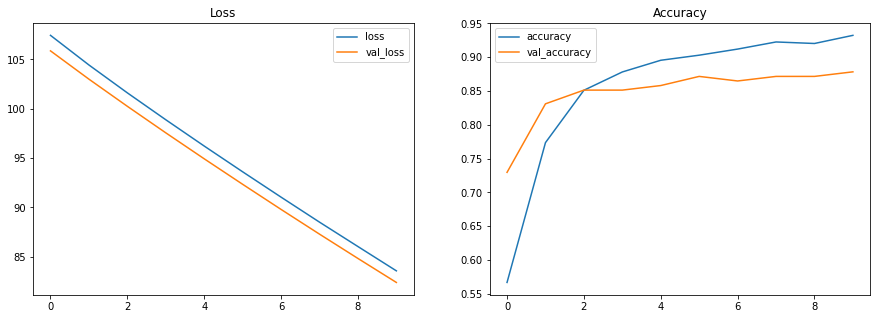

6/6 [==============================] - 1s 192ms/step - loss: 82.4252 - accuracy: 0.8848
[82.42515563964844, 0.8848484754562378]


In [45]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 10

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "mobilenetv2_train_base_True"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = True)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5")
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch, 
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **MobileNet - Transfer Learning (From TFHub)**

[TensorFlow Hub](https://tfhub.dev/) is a repository where hundreds of machine learning models come together in one place

In [46]:
# Build Model
def build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=train_base),
        keras.layers.Dense(units=64, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='tfhub_mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

Model: "tfhub_mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________
None


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▆▇▇▇█▇███
val_loss,█▇▆▆▅▄▃▂▂▁
GFLOPs,0.29969
accuracy,0.93233
best_epoch,9
best_val_loss,82.39196
epoch,9
loss,83.56847


Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 55.7360 - accuracy: 0.4256

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 25s 515ms/step - loss: 55.7360 - accuracy: 0.4256 - val_loss: 54.8976 - val_accuracy: 0.5473
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 54.1410 - accuracy: 0.6226

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 19s 460ms/step - loss: 54.1410 - accuracy: 0.6226 - val_loss: 53.4058 - val_accuracy: 0.6419
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 52.6752 - accuracy: 0.7256

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 479ms/step - loss: 52.6752 - accuracy: 0.7256 - val_loss: 51.9767 - val_accuracy: 0.7027
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 51.2649 - accuracy: 0.7789

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 482ms/step - loss: 51.2649 - accuracy: 0.7789 - val_loss: 50.5954 - val_accuracy: 0.7568
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 49.8968 - accuracy: 0.8090

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 489ms/step - loss: 49.8968 - accuracy: 0.8090 - val_loss: 49.2466 - val_accuracy: 0.7838
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 48.5615 - accuracy: 0.8278

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 481ms/step - loss: 48.5615 - accuracy: 0.8278 - val_loss: 47.9261 - val_accuracy: 0.8108
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 47.2530 - accuracy: 0.8421

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 19s 467ms/step - loss: 47.2530 - accuracy: 0.8421 - val_loss: 46.6310 - val_accuracy: 0.8176
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 45.9691 - accuracy: 0.8534

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 484ms/step - loss: 45.9691 - accuracy: 0.8534 - val_loss: 45.3600 - val_accuracy: 0.8311
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 44.7075 - accuracy: 0.8654

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 19s 465ms/step - loss: 44.7075 - accuracy: 0.8654 - val_loss: 44.1096 - val_accuracy: 0.8446
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 43.4676 - accuracy: 0.8722

wandb: Adding directory to artifact (/content/wandb/run-20220914_064605-3n5d8jsg/files/model-best)... Done. 0.1s


42/42 [==============================] - 20s 485ms/step - loss: 43.4676 - accuracy: 0.8722 - val_loss: 42.8810 - val_accuracy: 0.8446
Training execution time (mins) 3.5038145422935485


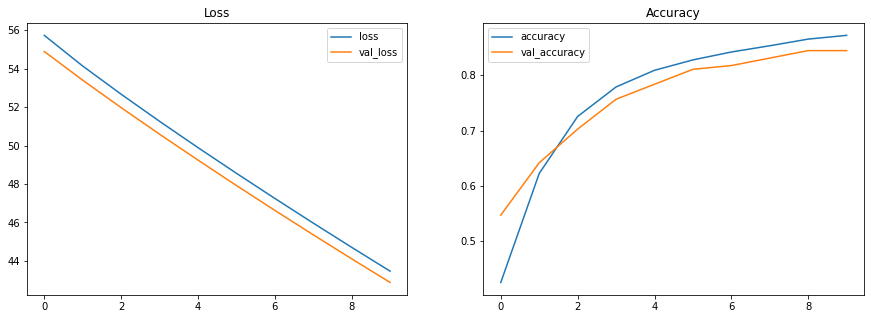

6/6 [==============================] - 1s 207ms/step - loss: 42.8341 - accuracy: 0.8788
[42.83409118652344, 0.8787878751754761]


In [47]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 10

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "tfhub_mobilenetv2_train_base_False"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+2

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

### **Train - Fine-Tuning**

Unfreeze the base

Model: "tfhub_mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,340,163
Trainable params: 2,306,051
Non-trainable params: 34,112
_________________________________________________________________
None


accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▇▆▅▅▄▃▂▂▁
GFLOPs,0.29976
accuracy,0.87218
best_epoch,9
best_val_loss,42.88098
epoch,9
loss,43.46761


Epoch 1/10
 6/42 [===>..........................] - ETA: 8s - loss: 56.5247 - accuracy: 0.2917

42/42 [==============================] - ETA: 0s - loss: 55.7213 - accuracy: 0.4962

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 30s 553ms/step - loss: 55.7213 - accuracy: 0.4962 - val_loss: 54.9097 - val_accuracy: 0.5676
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 54.0720 - accuracy: 0.7466

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 24s 572ms/step - loss: 54.0720 - accuracy: 0.7466 - val_loss: 53.3160 - val_accuracy: 0.7568
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 52.5715 - accuracy: 0.8368

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 22s 531ms/step - loss: 52.5715 - accuracy: 0.8368 - val_loss: 51.8608 - val_accuracy: 0.7905
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 51.1492 - accuracy: 0.8714

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 24s 568ms/step - loss: 51.1492 - accuracy: 0.8714 - val_loss: 50.4808 - val_accuracy: 0.8446
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 49.7709 - accuracy: 0.8992

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 22s 529ms/step - loss: 49.7709 - accuracy: 0.8992 - val_loss: 49.1456 - val_accuracy: 0.8716
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 48.4564 - accuracy: 0.8992

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 23s 551ms/step - loss: 48.4564 - accuracy: 0.8992 - val_loss: 47.8361 - val_accuracy: 0.8784
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 47.1496 - accuracy: 0.9135

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 22s 525ms/step - loss: 47.1496 - accuracy: 0.9135 - val_loss: 46.5543 - val_accuracy: 0.8784
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 45.8667 - accuracy: 0.9278

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 24s 577ms/step - loss: 45.8667 - accuracy: 0.9278 - val_loss: 45.2935 - val_accuracy: 0.8986
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 44.6151 - accuracy: 0.9323

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 23s 546ms/step - loss: 44.6151 - accuracy: 0.9323 - val_loss: 44.0541 - val_accuracy: 0.8986
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 43.3714 - accuracy: 0.9406

wandb: Adding directory to artifact (/content/wandb/run-20220914_064952-14ko9dza/files/model-best)... Done. 0.1s


42/42 [==============================] - 24s 571ms/step - loss: 43.3714 - accuracy: 0.9406 - val_loss: 42.8329 - val_accuracy: 0.8986
Training execution time (mins) 5.179079294204712


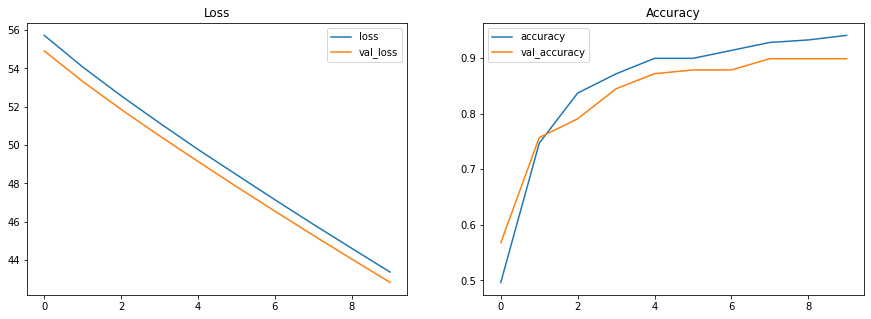

6/6 [==============================] - 1s 188ms/step - loss: 42.8089 - accuracy: 0.9091
[42.80891799926758, 0.9090909361839294]


In [48]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 10

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy

# Build or Load Model
model_name = "tfhub_mobilenetv2_train_base_True"
if not LOAD_PREV_TRAINED:
  # Build the model
  model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = True)

  # Print the model architecture
  print(model.summary())

  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
else:
  # Load model
  model = keras.models.load_model(PREV_EXPERIMENT+"/"+model_name+".hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  with open(PREV_EXPERIMENT+"/"+model_name+"_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open(PREV_EXPERIMENT+"/"+model_name+"_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+2

# W&B
wandb.init(project='mushroom-app-demo')
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "model_name": model_name
}
wandb.run.name = model_name
wandb.run.save()

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[WandbCallback()],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,prev_training_history)
  execution_time = model_metrics["execution_time"] + execution_time

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

# Update W&B
wandb.config.update({"execution_time": execution_time})

## **<font color="#A41034">Experiment Results</font>**

#### **Compare Models**

In [49]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(experiment_name+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"2,306,051",5.18 mins,42.81,90.91%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_True
2,"2,388,227",6.44 mins,82.43,88.48%,10 MB,0.001,32,10,SGD,mobilenetv2_train_base_True
1,"82,179",3.50 mins,42.83,87.88%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_False
5,"164,355",9.09 mins,70.93,87.27%,10 MB,0.001,32,15,SGD,mobilenetv2_train_base_False
3,"25,950,531",7.56 mins,0.89,63.03%,104 MB,0.010,32,25,SGD,2_block
4,"11,112,323",12.62 mins,1.01,50.30%,44 MB,0.010,32,25,SGD,4_block
6,"22,514,755",6.81 mins,1.11,41.21%,90 MB,0.010,32,15,SGD,vgg_style


#### **Find Best Model**

In [50]:
best_model = experiment_name+'/'+view_metrics.iloc[0]["name"]+".hdf5"
print(best_model)

experiment_1663135312/tfhub_mobilenetv2_train_base_True.hdf5


### **Predict using the best model**

In [51]:
# Load a model from disk
prediction_model = tf.keras.models.load_model(best_model, custom_objects={'KerasLayer':hub.KerasLayer})
#prediction_model = tf.keras.models.load_model(best_model)
prediction_model.summary()

Model: "tfhub_mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,340,163
Trainable params: 2,306,051
Non-trainable params: 34,112
_________________________________________________________________


predictions.shape: (12, 3)
[0.268631   0.25303245 0.47833654] 2


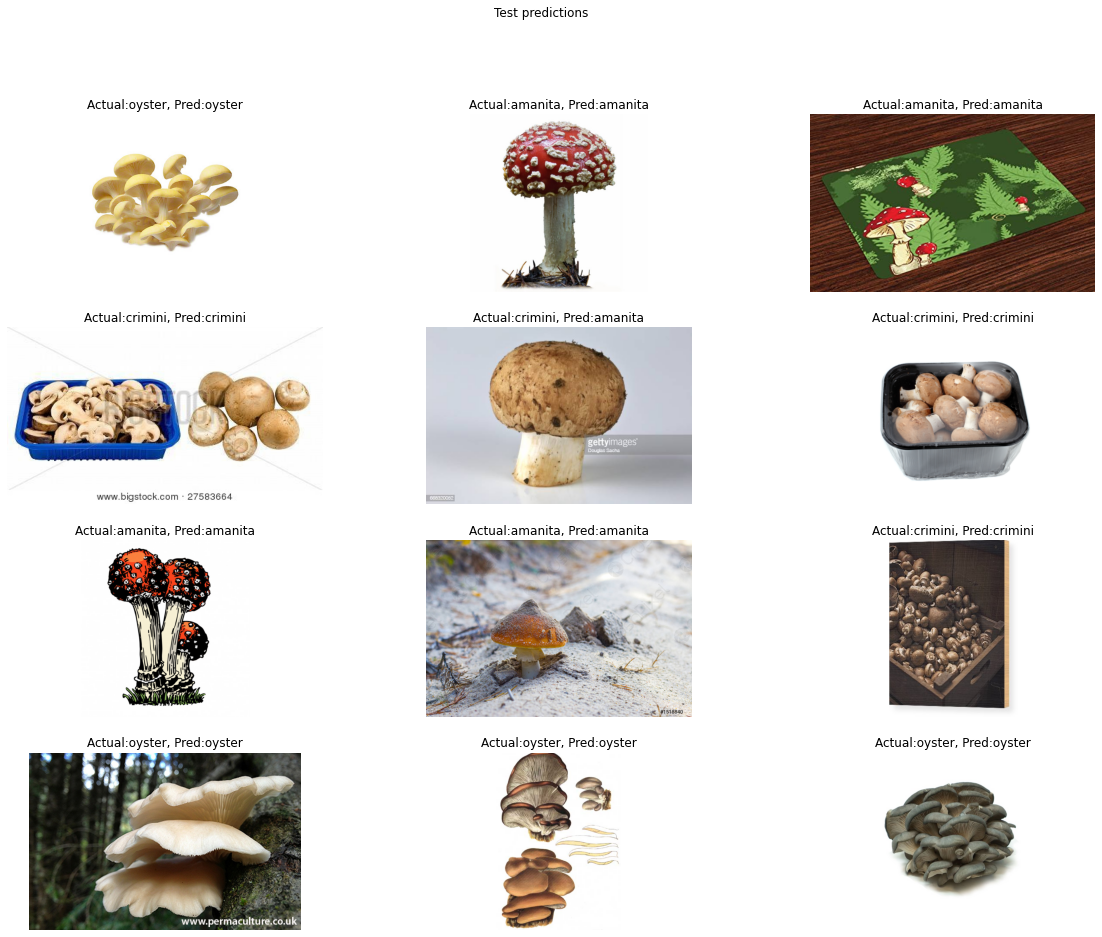

In [52]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)
    
    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()